<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basic-Data-Exploration" data-toc-modified-id="Basic-Data-Exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic Data Exploration</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#ONLINE-Dataset" data-toc-modified-id="ONLINE-Dataset-1.0.0.1"><span class="toc-item-num">1.0.0.1&nbsp;&nbsp;</span>ONLINE Dataset</a></span></li><li><span><a href="#ORDER-Dataset" data-toc-modified-id="ORDER-Dataset-1.0.0.2"><span class="toc-item-num">1.0.0.2&nbsp;&nbsp;</span>ORDER Dataset</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Data-Preparation-&amp;-Feature-Engineering" data-toc-modified-id="Data-Preparation-&amp;-Feature-Engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation &amp; Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Log-Transformation-of-skewed-features" data-toc-modified-id="Log-Transformation-of-skewed-features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Log Transformation of skewed features</a></span></li><li><span><a href="#Scaling-the-data" data-toc-modified-id="Scaling-the-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Scaling the data</a></span></li></ul></li><li><span><a href="#Modeling--K-means" data-toc-modified-id="Modeling--K-means-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling- K means</a></span><ul class="toc-item"><li><span><a href="#Defining-Model" data-toc-modified-id="Defining-Model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Defining Model</a></span></li><li><span><a href="#Elbow-graph-to-choose-number-of-clusters" data-toc-modified-id="Elbow-graph-to-choose-number-of-clusters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Elbow graph to choose number of clusters</a></span></li><li><span><a href="#Cluster-Scores" data-toc-modified-id="Cluster-Scores-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Cluster Scores</a></span></li></ul></li></ul></div>

In [5]:
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
from sklearn import metrics
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import datetime as dt
from sklearn.manifold import TSNE

In [6]:
online = pd.read_csv('online.csv', dtype={'session':'int64', 'visitor':'int64' }, parse_dates=['dt'])
order = pd.read_csv('order.csv',parse_dates=['orderdate'])

online.sort_values(by = ['dt'], inplace =True)
order.sort_values(by = ['orderdate'], inplace =True)

In [7]:
order.head(2)

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
172053,67913,143380,2016-01-01 05:05:14,38.0,5,139.77
55927,10880,15272,2016-01-01 06:34:56,4.0,2,147.51


In [8]:
online.head(2)

,session,visitor,dt,custno,category,event1,event2
461633,1599047,258187,2016-01-01 00:00:08,36112,3,NaN,7
26704,284812,419022,2016-01-01 00:01:47,68246,1,NaN,7


# Basic Data Exploration

#### ONLINE Dataset
- Data ranges from 2016-01-01 to 2017-12-31
- event1 has 10 unique values
- event2 has 10 unique values
- 3 category : 3,2,1
- Dataset has 954774 values
- has 57584 unique custno
- has 259950 unique visitor
- has 850235 unique session

#### ORDER Dataset
- Data ranges from 2016-01-01 to 2019-01-02
- 6 prodcat1: 1,2,3,4,5,7
- has 252 prodcat2
- revenue ranges from 0 to 150, mean~75, std dev~43
- Dataset has 263278 values
- has 70264 unique custno
- has 149717 unique ordno

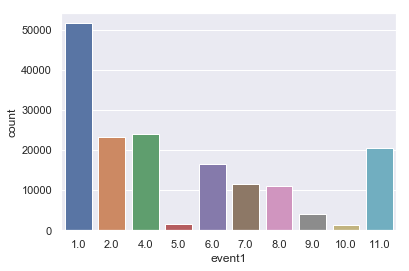

In [176]:
sns.countplot(online['event1'])

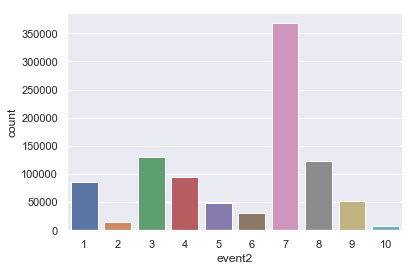

In [177]:
sns.countplot(online['event2'])

Text(0.5, 1.0, 'revenue per prodcat1')

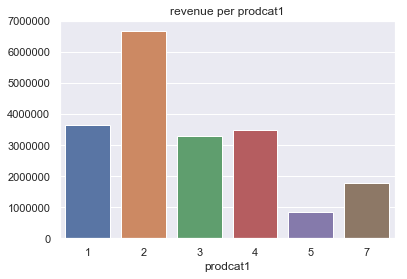

In [178]:
ax = sns.barplot(x=order.groupby(['prodcat1']).revenue.sum().keys(), y=order.groupby(['prodcat1']).revenue.sum().values)
plt.title("revenue per prodcat1")


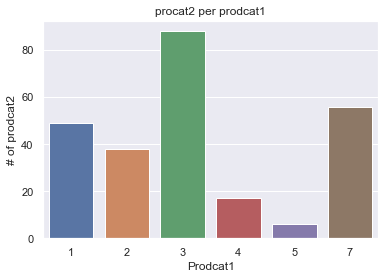

In [179]:
prodcat1_2_ = order[['prodcat1', 'prodcat2']].drop_duplicates()
#prodcat1_2_.groupby(['prodcat1']).prodcat2.count()
ax= sns.barplot(prodcat1_2_['prodcat1'].value_counts().keys(), prodcat1_2_['prodcat1'].value_counts().values)
plt.title("procat2 per prodcat1")
plt.ylabel('# of prodcat2', fontsize=12)
plt.xlabel('Prodcat1', fontsize=12)
plt.show()

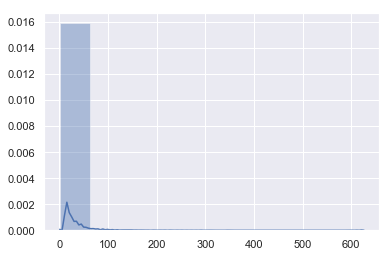

In [180]:
## Top customer in terms of number orders
x = order['custno'].value_counts()
sns.distplot(x.values, bins = 10);

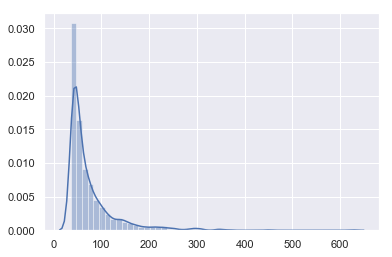

In [181]:
x_top100 = order['custno'].value_counts()[:1000]
sns.distplot(x_top100.values, bins = 50);

In [182]:
def missing_data(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    missing_df['percentage_missing']= missing_df['missing_count']/len(data)
    return missing_df

In [183]:
missing_data(order) 

,column_name,missing_count,percentage_missing
3,prodcat2,1823,0.006924


In [184]:
missing_data(online) ## since 82% data is missing for event1, hence drop event1

,column_name,missing_count,percentage_missing
5,event1,789846,0.82726


# Data Preparation & Feature Engineering

1) Filter Order data for the same timeline as Online data
<br>
2) Derive features from order data: recency, customer_age (i.e. first order date), monetary, prodcat1 distinct count, prodcat2 distinct count
<br>
3) Derive features from online data: days from last online event, event frequency
<br>
4) Merge order and online faetures at index level (which is custno)

In [147]:
# get last date of online data
end_date = online['dt'].max()

order_16_17 = order[order['orderdate']<= end_date]
# # Filter 1-year data range from original df
# start_date = end_date - pd.to_timedelta(364, unit='d')
# df_rfm = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Create hypothetical snapshot date
snapshot_date = end_date + dt.timedelta(days=1)

order_16_17['orderdate_dup'] = order_16_17['orderdate'] 
# Calculate Recency, Frequency and Monetary value for each customer
df_rfm = order_16_17.groupby(['custno']).agg({
    'orderdate': lambda x: (snapshot_date - x.max()).days, ## date of last order
    'orderdate_dup': lambda x: (snapshot_date - x.min()).days, ## date of first order
    'ordno': pd.Series.nunique,
    'revenue': 'sum',
    'prodcat1': pd.Series.nunique})

# Rename the columns
df_rfm.rename(columns={'orderdate': 'Recency',
                       'orderdate_dup': 'cust_age',
                       'ordno': 'Frequency',
                       'revenue': 'MonetaryValue',
                       'prodcat1': 'prodcat1_distinct_cnt'}, inplace=True)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [148]:
print (len(order_16_17['custno'].unique()))
print (len(df_rfm))
df_rfm.head(2)

48819
48819


,Recency,cust_age,Frequency,MonetaryValue,prodcat1_distinct_cnt
custno,,,,,
1,203,203,1,8.35,1
2,244,706,5,426.11,2


In [149]:
## Derive feature from online data 

online_rfm = online.groupby(['custno']).agg({'event2': 'count'})
online_rfm.rename(columns={'event2': 'event_frequency'}, inplace=True)
online_rfm.head(2)


,event_frequency
custno,
6,11
7,9


In [150]:
# Merge online and order data features
final_rfm = pd.merge(df_rfm, online_rfm, how = 'left', left_index=True, right_index=True)
print (len(df_rfm))
print (len(final_rfm))
final_rfm.head(2)

48819
48819


,Recency,cust_age,Frequency,MonetaryValue,prodcat1_distinct_cnt,event_frequency
custno,,,,,,
1,203,203,1,8.35,1,NaN
2,244,706,5,426.11,2,NaN


In [151]:
# Impute missing values
final_rfm['event_frequency'].fillna(0, inplace = True)
final_rfm.head(2)

,Recency,cust_age,Frequency,MonetaryValue,prodcat1_distinct_cnt,event_frequency
custno,,,,,,
1,203,203,1,8.35,1,0.0
2,244,706,5,426.11,2,0.0


In [152]:
from scipy import stats

def target_var_info(data, target_var_name):
    description = data[target_var_name].describe()

    sns.distplot(data.loc[:,target_var_name])
    
    fig = plt.figure()
    #res = stats.probplot(data.loc[:,target_var_name], plot=plt)
    
    skewness = (data.loc[:,target_var_name].skew())
    kurtosis = (data.loc[:,target_var_name].kurt())
    
    return plt.show(), fig.show(), description,  skewness, kurtosis 

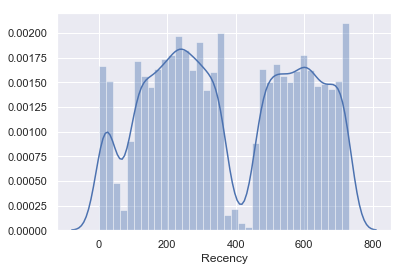

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


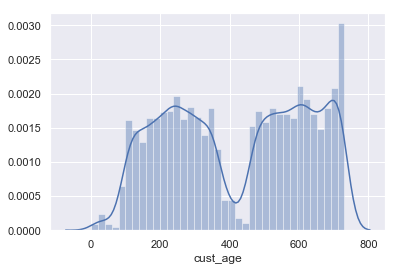

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


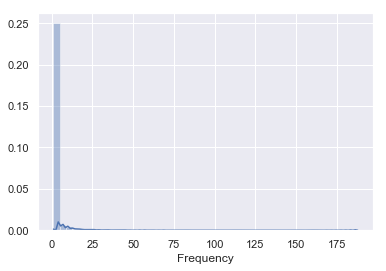

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


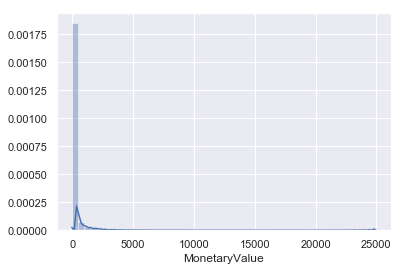

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


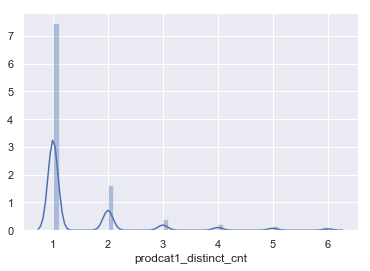

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


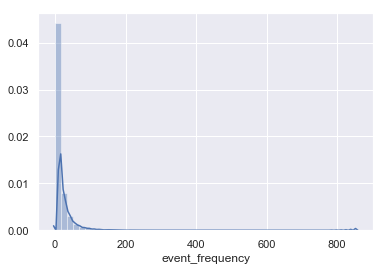

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [153]:
for var in final_rfm.columns:
    target_var_info(final_rfm, var)


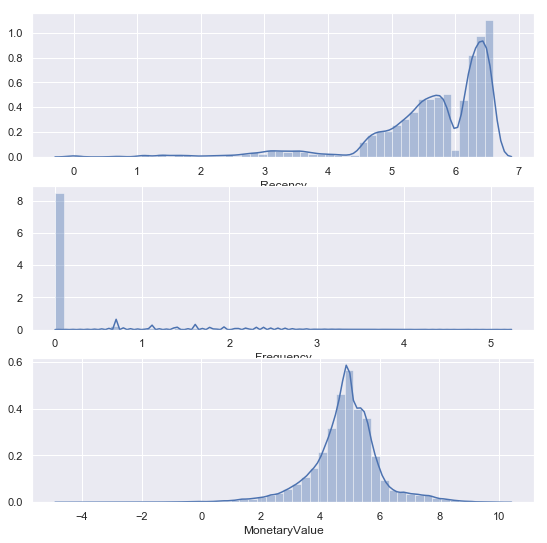

In [154]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
sns.distplot(np.log(df_rfm['Recency']));

plt.subplot(3, 1, 2)
sns.distplot(np.log(df_rfm['Frequency']));

plt.subplot(3, 1, 3)
sns.distplot(np.log(df_rfm['MonetaryValue']));


## Log Transformation of skewed features

In [158]:
# Log transformation to deal with skewness
df_rfm_log = final_rfm.copy()
df_rfm_log['Recency'] = np.log(df_rfm_log['Recency'] )
df_rfm_log['Frequency'] = np.log(df_rfm_log['Frequency'] )
df_rfm_log['MonetaryValue'] = np.log(df_rfm_log['MonetaryValue'] )
df_rfm_log['cust_age'] = np.log(df_rfm_log['cust_age'] )
#df_rfm_log['event_frequency'] = np.log(df_rfm_log['event_frequency'] )

df_rfm_log.head(2)

,Recency,cust_age,Frequency,MonetaryValue,prodcat1_distinct_cnt,event_frequency
custno,,,,,,
1,5.313206,5.313206,0.000000,2.122262,1,0.0
2,5.497168,6.559615,1.609438,6.054698,2,0.0


## Scaling the data

In [159]:
# Scaling data
scaler = StandardScaler()
scaler.fit(df_rfm_log)
final_rfm = scaler.transform(df_rfm_log)

final_rfm = pd.DataFrame(final_rfm, index=df_rfm_log.index, columns=df_rfm_log.columns)

# Check result after standardising
final_rfm.describe().round(3)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,Recency,cust_age,Frequency,MonetaryValue,prodcat1_distinct_cnt,event_frequency
count,48819.000,48819.000,48819.000,48819.000,48819.000,48819.000
mean,-0.000,-0.000,-0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000
min,-5.656,-9.536,-0.305,-8.041,-0.463,-0.599
25%,-0.353,-0.655,-0.305,-0.439,-0.463,-0.516
50%,0.201,0.392,-0.305,0.046,-0.463,-0.311
75%,0.726,0.833,-0.305,0.513,0.612,0.101
max,0.963,1.134,7.581,4.491,4.909,34.562


In [160]:
final_rfm.columns

Index(['Recency', 'cust_age', 'Frequency', 'MonetaryValue',
       'prodcat1_distinct_cnt', 'event_frequency'],
      dtype='object')

# Modeling- K means

## Defining Model

In [161]:
def optimal_kmeans(dataset, start=2, end=9):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values and line plot of Silhouette Score.
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
    km_ss = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calcualte model performance
        silhouette_avg = round(silhouette_score(dataset, labels, random_state=1), 3)

        # Append score to lists
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)

        print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(6.47,3))

            plt.title('Silhouette Score')
            sns.pointplot(x=n_clu, y=km_ss)
            plt.savefig('silhouette_score.png', format='png', dpi=1000)
            plt.tight_layout()
            plt.show()


## Elbow graph to choose number of clusters

No. Clusters: 2, Silhouette Score: 0.621, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.329, Change from Previous Cluster: -0.292
No. Clusters: 4, Silhouette Score: 0.349, Change from Previous Cluster: 0.02
No. Clusters: 5, Silhouette Score: 0.327, Change from Previous Cluster: -0.022
No. Clusters: 6, Silhouette Score: 0.325, Change from Previous Cluster: -0.002
No. Clusters: 7, Silhouette Score: 0.294, Change from Previous Cluster: -0.031
No. Clusters: 8, Silhouette Score: 0.301, Change from Previous Cluster: 0.007


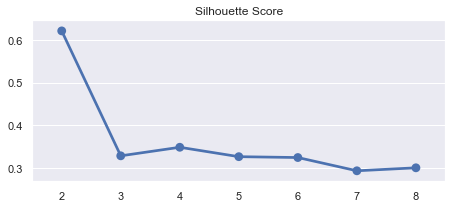

In [162]:
optimal_kmeans(final_rfm, start=2, end=9)

In [163]:
def kmeans(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    return df_new, cluster_labels


In [164]:
df_rfm_k3 = kmeans(final_rfm, 3)
df_rfm_k4 = kmeans(final_rfm, 4)
df_rfm_k5 = kmeans(final_rfm, 5)

In [175]:
df_rfm_k4[0].head()

,Recency,cust_age,Frequency,MonetaryValue,prodcat1_distinct_cnt,event_frequency,Cluster
custno,,,,,,,
1,-0.322928,-0.938966,-0.304590,-2.317135,-0.462799,-0.598592,3
2,-0.138285,1.077802,2.118961,1.028735,0.611644,-0.598592,0
3,-0.010966,-0.128439,2.393508,1.269428,-0.462799,-0.598592,3
4,-0.884614,-1.080480,2.625634,0.855344,-0.462799,-0.598592,3
5,0.942211,1.100560,-0.304590,-0.289604,-0.462799,-0.598592,0


## Cluster Scores

In [172]:
def rfm_values(df):
    '''
    Calcualte average RFM values and size for each cluster

    '''
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'cust_age': 'mean',
        'prodcat1_distinct_cnt': 'mean',
        'MonetaryValue': ['mean', 'count'],
        'event_frequency': 'mean'
    })
    
    return df_new



In [173]:
rfm_values(df_rfm_k3[0])

Recency Frequency  cust_age prodcat1_distinct_cnt MonetaryValue  \
             mean      mean      mean                  mean          mean   
Cluster                                                                     
0       -0.443686 -0.248510 -1.036713             -0.200944     -0.098835   
1        0.644384 -0.257396  0.646309             -0.227528     -0.192937   
2       -2.429547  3.222349  0.692918              2.749371      1.952882   

               event_frequency  
         count            mean  
Cluster                         
0        18846       -0.029745  
1        26410       -0.015473  
2         3563        0.272023

In [174]:
rfm_values(df_rfm_k4[0])

Recency Frequency  cust_age prodcat1_distinct_cnt MonetaryValue  \
             mean      mean      mean                  mean          mean   
Cluster                                                                     
0        0.646233 -0.256690  0.649020             -0.233360     -0.193601   
1       -2.431845  3.224983  0.692551              2.754776      1.954359   
2        0.214953 -0.259005 -0.026953             -0.100481     -0.152958   
3       -0.451599 -0.246667 -1.044547             -0.205371     -0.096570   

               event_frequency  
         count            mean  
Cluster                         
0        25180       -0.179594  
1         3549        0.245145  
2         2147        3.287739  
3        17943       -0.189858

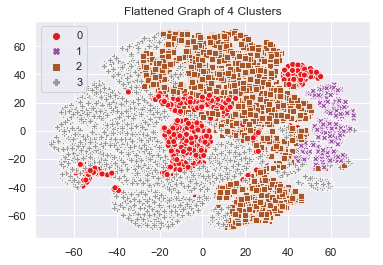

In [170]:
model = TSNE(random_state=1)
transformed = model.fit_transform(final_rfm)

# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(4))
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
plt.savefig('Cluster.png', format='png', dpi=1000)
